# Last.fm Genre Recommender Engine: Technical Report
#### Stewart Knox, Capstone Project
#### DSI-Plus-2, General Assembly
- Executive Presentation: https://docs.google.com/presentation/d/1IdYEQRfHaUBnlcuUhtVBmrqcbCkid-4nrLDSqU5cTAc/edit#slide=id.p4


# Executive Summary

#### Problem statement/goal
1. Many music recommenders out there are focused on the short term: what song does a user want to listen to right now, or what artist?  That's fine for most users, but I want to target a different demographic - the music listener with a wide range of tastes that wants to find entire new genres to listen to, ideally ones they've never heard before.
2. To accomplish this, a custom-weighted data set of user/genre profiles was built to determine what genres a given user might be interested to give new, deep wells for them to draw from.
3. Using a given random user, the 10 most similar users were found using Cosine Similarity, SVD, and Jaccard distance.  Our random user was then presented with a list of genres common among these 10 but that he/she had not yet listened to. 

#### Key metrics 
1. What does a "good" recommendation look like?  The key task was removing "junk" genres without removing obscure genres using a custom weighting algorithm
    - No macro-genres (Rap, Rock, Alternative)
    - No "junk" genres (Seen Live, North Korea Is Best Korea)
    - We want the micro-genres in between (Hard Trance, Japanese Synthpop, Sleaze Rock, Post-Hardcore)
2. Since this is static data, we can't put it in front of a user and see if they like the new genre, so testing will occur using different time periods - did a user listen to a genre in the latter time period that we predicted they would like?

#### Findings
1. Criteria 1 is met, by and large.  There are some macro-genres that get into recommendations, mostly due to variance in the names that can occur when comparing one user's profile to many users' profiles, but they are manageable.  And very few junk genres get in to our results.
2. Criteria 2 shows about a 50% hit ratio for recommendations, which is to say that 50% of users listen to at least one of the recommended genres in the following year.  More information is available in 4-time_based_tts.ipynb.

#### What Risks/limitations/assumptions affect these findings?
1. The weighting algorithm currently assumes the following:
    - A value of zero is "haven't heard" rather than "don't like", and is thus a viable recommendation
    - More listens = more likes
    - That the user has not listened to this genre in the past (potentially very problematic!)
    - Problems can arise when comparing prolific users with low-listen users, since most of a low-listen user's genres will be wiped out when comparing to their prolific colleagues
2. The time train/test split assumes:
    - That all genres were available to the user before and after
    - That no significant new songs in another genre came out before and after
    - Weight also prefers artists who have been around for a longer portion of the time period

#### Learning Takeaways
- Engineering and managing large datasets
- Buffing up SQL skills
- ...learning that data collection, cleaning, and trimming is often 90% of the problem

#### Future features
1. Give me a artist "deep dive" of a genre - who are the most popular, big names in the genre, the up-and-coming, and some of the obscure (i.e. small number of listeners with high number of scrobbles)

# Gathering Data
1. Full cleaning code available in 1-capstone_eda.ipynb
1. Began with these two data sets which were pulled from www.last.fm.  At 17 and 19 million rows, these unpacked to more than 1GB each
    - 360k users with artist/plays http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-360K.html
    - 1000 users with time/date/artist/track http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-1K.html
    - Much computation power was required to load and manipulate these data sets.  Many pickles were had.  And 16GB later, my iCloud hates me.

    <img src="img/gathering1.png" alt="Smiley face" height="200" width="700">

2. Adding genre information from last.fm
    - Last.fm dataset have plays but no genres, requiring an API pull to augment this data
        - Set up connection to a MongoDB hosted on AWS and built a function to extract and load
        - Last.fm allows only 100mb of data to be extracted at a rate of ~1-5 connections per second
        - With 186,400 unique artists and ~400-700mb of genre data to be extracted, this took a long time and a prodigious use of sleep(0.2) in my for loops
    <img src="img/gathering2.png" alt="Smiley face" height="200" width="700">
    <img src="img/gathering3.png" alt="Smiley face" height="150" width="500">

3. NaNs
    - Many NaNs in artmbid, which I dropped because I needed artmbid to look up genres from the Last.fm API.  Reduced data by 40-50%, but excluded many junk artists like "!www.music.com"
        - Last.fm API does have a name spelling corrector, but I would have to clean my data in exactly the same way to match these back up.  
        - Generated total_unique_artist_ids which covers all artists from both datasets

# EDA
#### Variables of interest - Genres, Plays, and Time
- Genre.  What does this look like per artist and per user?
    - Each artist can have up to 100 (user-supplied) genres.  Clear spikes for popular artists
        - Very clean data that shows smooth drop down with spikes at 0/100
        - Safe to remove all artists tagged with zero genres
        - Unsafe to remove artists in between
    - Similarly, each genre has up to 100 votes.  Clear spikes for popular genres, but the bulk are in the 20 range
        - Noisier.  Shows that the popular artist/genre combos are well-tagged at 100, but most fall in the 1-20 tags range.  Can't eliminate these - this is the bulk of artists!  Both signal and noise present here

    <img src="img/eda1.png" alt="Smiley face" height="200" width="700">
    <img src="img/eda2.png" alt="Smiley face" height="100" width="700">
    <img src="img/eda3.png" alt="Smiley face" height="100" width="700">
- Plays.  From both databases, we have artist name and plays, so we can match plays with genres (once cleaned and weighted) to determine a genre profile for the user
- Time.  The lastfm_1k database has times associated with plays, allowing us to construct a train/test split to validate our genre recommendation model and determine if a user listens to the genres we think they'll like.

#### Outliers and junk removed
- Initial pull, out of 4 million genre tags and 186k users, had 324k unique genres, many of which were total garbage
    - Removing tags that only appeared 30 times or less dropped genres down to 11,188 unique.  Much better!
        - Cost: about 1% of artists.  Gain: 96% reduction in genre noise
<img src="img/eda3.5.png" alt="Smiley face" height="200" width="700">
<img src="img/eda4.png" alt="Smiley face" height="125" width="400">

    - Removed popular (but meaningless) genres like "seen live", "spotify", "under 2000 listeners"
- Hesitant to cut further
    - Popular artists will likely have more votes per genre.  If I cut everything off that doesn't have 100 votes, I lose a lot of lesser artists and lesser genres. 
    - Need a way to weight the information without popular artists overwhelming everything (see Genre Percent Weight Algorithm below)



#### Data imputation
- Levenshtein distance
    - Many genre names are similar and could/should be combined, i.e. 
        - "German hip-hop"
        - "German hip hop"
        - "German hiphop"
        - also..."Deutscher Hip-Hop"
    - Borrowing a Levenshtein function for python and modifying a clustering algorithm, I output all genres that were related within a distance of 1
    <img src="imp1.png" alt="Smiley face" height="200" width="700">

    - Problem 1: false positives.  Many distinct genres are related within distance 1 (i.e. clusters of '00s', '90s', '80s', '70s', '60s', etc).  However, many garbage genres were also clustered together, helping me to eliminate them more easily.  
    - Problem 2: I was unable to find a satisfactory, canonical, "known good" genre list to normalize.  Ultimately, genre curation beyond this point would be a manual and time-consuming process, and would only deduplicate about 10% of genres overall, so I ceased after eliminating about 300 genres with this method. 
        - More details available in 2-EDA-graphs

<img src="img/imp2.png" alt="Smiley face" height="200" width="700"> 

#### <img src="img/imp3.png" alt="Delete List" height="200" width="400">

- Engineering Challenges
    - At this point, I moved my data to a SQLite database because the file sizes were unmanageable in Docker on a laptop with enough RAM to hold only one or two of them at a time.
    - Many functions were offloaded to the server, but some functions (like pivoting) are not part of SQLite, requiring pivoting to be done in Docker.
    - SQLite worked much better for subsequent queries, but be wary of how iCloud handles files like these!


# Building my full dataset: a matrix of users with genre profiles
### Genre Percent Weight Algorithm
- First, I performed a LEFT JOIN to combine my user/artist/plays data with artist/genre data
- In order to reduce the effect of popular artists with many many high-voted genres, I scaled each genre by the total number of votes given to that genre.  This is a version of controlling for variance, and ensures that artists with a high number of genres don't overwhelm the genre profile of a user.  It also does perform a bit of bias against artists that are very popular as signified by a high number of votes
    - This will then allow us to filter out the low end which will keep both (a) popular artists with low plays, and (b) less popular artists with high plays, giving us a better picture of the user's overall genre profile
    - The distribution of genre percents bears this out.  Most artists have multiple tags (5 tags at 100 votes each would give 20% genre_percent).  There are fewer junk entries in here (anything below about 15%), but this ensures that they will show up less frequently in the user's profile.

<img src="img/gwa1.png" alt="threshold code" height="200" width="700">

<img src="img/gwa2.png" alt="Smiley face" height="200" width="700">

<img src="img/gwa3.png" alt="Smiley face" height="200" width="700">



### Building a user genre profile vector
- create a set of vectors for the user based on their artist/plays/genre combination using our custom weighting algorithm
- multiply each row by the # of plays
- then add all together for a total vector of the user
- this acts as a sort of manual TFIDF that carries forward the genre weighting

### then combine with other users to form a preference matrix
- build a function to generate an arbitrary list of users on which to run our models


In [1]:
import pandas as pd, numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display
%matplotlib inline
import pickle
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
import sqlite3
# con = sqlite3.connect("../lastfm_1k_sql")

In [2]:
# note that this SQL code will not work on github because the 4.5gb SQL database cannot be
# hosted on github.  skip to the pickled model section below.

# select n random userids
def select_random_users(num_users):
    sql = ("SELECT DISTINCT usersha1 "
           "FROM lastfm_360k_sql "
           "ORDER BY Random() "
           "LIMIT'{0}'").format(num_users)

    user_list = pd.read_sql(sql, con=con)
    return user_list

In [3]:
# a function to build and weight the user genre profile into a (1,n) vector, where n = their # of listened genres
# - this  creates a set of vectors for the user
# - then multiplies each row by the # of plays
# - then add all together for a total vector of the user

def build_user_vector(usersha, test_values=False, scale_by_plays=True, full_matrix=False):

    # pull all artists/plays for a given user
    sql = ("SELECT lastfm_360k_sql.usersha1, lastfm_360k_sql.artmbid, lastfm_360k_sql.artname, lastfm_360k_sql.plays "
           "FROM lastfm_360k_sql "
           "WHERE lastfm_360k_sql.usersha1 = '{0}' ").format(usersha)
    user1 = pd.read_sql(sql, con=con)
    
    # build string of artist ids corresponding to the user in order to query sql
    new_str = ''
    for ids in list(user1['artmbid']):
        new_str += 'id = "{0}" or '.format(ids)
        
    # pull the user's artist/genre/percent mix.  SQL code could be used to build in a user-defined limit here
    sql = ("SELECT artist_genre_percent_sql.artmbid as id, "
           "artist_genre_percent_sql.genre, "
           "artist_genre_percent_sql.genre_percent "
           "FROM artist_genre_percent_sql "
           "WHERE {0}").format(new_str[:-4])
    artist_genre = pd.read_sql(sql, con=con)
    artist_genre.rename(columns={'id':'artmbid'}, inplace=True)
    
    # pivot the user's matrix so we don't have multiple columns with the same artist, and instead
    # put all genres out horizontally
    joined_matrix = artist_genre.pivot_table(values='genre_percent',
                                                    index='artmbid', 
                                                    columns='genre', 
                                                    dropna=False)
    
    # scale the user's genre preference by # of plays of that artist
    # error-checking here ensures that any artists missing from the SQL query do not gum up the pull
    if scale_by_plays:
        for artmbid1 in user1.artmbid.values:
            num_plays = user1.plays[user1.artmbid == artmbid1].values
            try:
                joined_matrix.loc[artmbid1] *= num_plays
            except KeyError:
                pass
            
    # returns all the non-null values in the matrix, summed by artist, as an error check to make sure our weights work
    if test_values:
        joined_matrix['e'] = joined_matrix.sum(axis=1)
        return joined_matrix['e'][~joined_matrix['e'].isnull()]
    
    # returns the full matrix (not collapsed into (1,n)) as an error check
    if full_matrix:
        return joined_matrix
    
    # return a dictionary with total genre profile of the user, indexed by usersha1
    else:
        joined_matrix.loc[usersha] = joined_matrix.sum()
        user_vector = joined_matrix.loc[usersha]
        return user_vector.to_dict()

In [4]:
# finally, build a genre taste matrix for specified number of random users
# output will be (m,n) dimensional, where m = the number of users and n = the set of their genres

def build_taste_matrix(num_users):
    
    # initialize a dictionary for each user, and an index list for each
    user_list_of_dicts = []
    index_list = []
    
    # gather the appropriate number of userids
    how_many = select_random_users(num_users)
    
    # for each userid, build a vector, then append it to the final list
    for i in tqdm(range(len(how_many))):
        useri_vector = build_user_vector(how_many['usersha1'][i])
        user_list_of_dicts.append(useri_vector)
        index_list.append(how_many['usersha1'][i])

    return pd.DataFrame(user_list_of_dicts, index=index_list)

#### capture 500 random users to use for processing

In [5]:
# no_accounting = build_taste_matrix(500)
# pickle.dump(no_accounting, open('no_accounting', "wb" ) )

In [2]:
no_accounting = pickle.load( open( "no_accounting", "rb" ) ) 
no_accounting_for_taste = no_accounting.fillna(0)
no_accounting_for_taste.index.name = 'usersha1'
no_accounting_for_taste.head()

,not ripped,psychedelic rock,'00s,'70s,'80s,'90s,-artist,-listen,0 play yet,00's,...,zup,zwing,zxzw,zxzw 2007,zxzw 2009,zxzw2009,zydeco,zz,zzzzzzzzzzzzz,österreich
usersha1,,,,,,,,,,,,,,,,,,,,,
bb1f61e8fccddd13b341563189e9a708d6b85e13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bb887c518d10546fa6cbafe4b826af311b2cbdbb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.430155,...,0.0,0.0,1.094505,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9b6ae0ec405278aaf14b79479e1b17880e0aaab8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c10000349f08b8b8c4136ff1a53af212846ecfc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3400ffa0cb7f40949b461069b38b25b771f79564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### we can now finally do our last bit of EDA!
- Mean genres per user and standard deviation, as well as distribution.  Most users have around 400-600 genres in their arsenal in a fairly normal distribution.

517.88599999999997

125.90776996307316

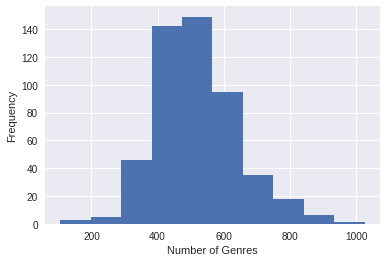

In [3]:
# mean number of genres per user
num_genres = (10648 - no_accounting.isnull().sum(axis=1))

# std in number of genres per user

display(num_genres.mean())
display(num_genres.std())

num_genres.plot.hist()
plt.xlabel('Number of Genres')

# Recommendation Engines
## Model selection - Cosine Similarity, SVD, Jaccard

### Cosine Similarity

usersha1,bb1f61e8fccddd13b341563189e9a708d6b85e13,bb887c518d10546fa6cbafe4b826af311b2cbdbb,9b6ae0ec405278aaf14b79479e1b17880e0aaab8,c10000349f08b8b8c4136ff1a53af212846ecfc3,3400ffa0cb7f40949b461069b38b25b771f79564,89fd0b6bfcf9e7ab4fbc89ff2425f260bdf6134d,de442dc920a2e656977b0b8eb5497e6070f72ab8,82c9e036a998209ee0b1ffd60441021e9e157253,c1394df26be84dc4b5d05707e4ccb5b8c748de00,75f7da51d3dfecff55a49e08fb976c969e156a1a,...,8b922e55d162bc4e37699e9381146af968473b9c,d9e3c977e51f5ad7009ca66f29d6201829518609,9c2a40cfedbac2e4da34f3b7cb8b1e616d32a47f,739c2514fd8a27076121f09524f2e9044170710f,6766c89c2a271720e3ac57e1191fd54ab61859de,f6a417b06102f3407f46aa40db6570b12e4b2102,a9ce7cce78b59cbe4aeceb5ae80994576a7adc0d,9c229993dac5c6d9387de8b88067c31227d87e9c,0e948a549e1d5d68d47c41858cc6c1e3ea83b290,33ca636574bb480f076a2ba3039e877dfd2054a4
usersha1,,,,,,,,,,,,,,,,,,,,,
bb1f61e8fccddd13b341563189e9a708d6b85e13,1.000000,0.189972,0.102310,0.219403,0.014269,0.285383,0.005933,0.048960,0.421646,0.093098,...,0.328486,0.064209,0.111353,0.031172,0.005774,0.354487,0.174669,0.069132,0.010289,0.061783
bb887c518d10546fa6cbafe4b826af311b2cbdbb,0.189972,1.000000,0.215840,0.894918,0.046565,0.218527,0.040394,0.118884,0.432702,0.199873,...,0.369617,0.173621,0.071712,0.196387,0.006851,0.723485,0.262265,0.118637,0.080458,0.116165
9b6ae0ec405278aaf14b79479e1b17880e0aaab8,0.102310,0.215840,1.000000,0.119089,0.056800,0.131763,0.008038,0.030963,0.228929,0.193772,...,0.121333,0.035830,0.267195,0.018978,0.007354,0.196426,0.065592,0.044358,0.010944,0.175574
c10000349f08b8b8c4136ff1a53af212846ecfc3,0.219403,0.894918,0.119089,1.000000,0.056154,0.306596,0.076130,0.114022,0.440716,0.194211,...,0.389086,0.176376,0.041092,0.192575,0.007426,0.736324,0.313764,0.179366,0.077615,0.119118
3400ffa0cb7f40949b461069b38b25b771f79564,0.014269,0.046565,0.056800,0.056154,1.000000,0.031406,0.141316,0.355685,0.444502,0.461425,...,0.059249,0.324819,0.005122,0.145215,0.616420,0.049470,0.121757,0.032655,0.084198,0.650715


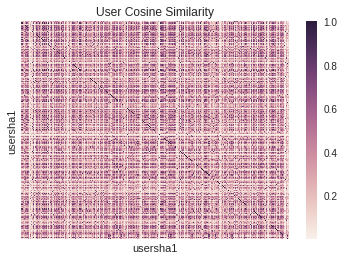

In [4]:
# we now have enough to build a similarity matrix

users_sim = pd.DataFrame(cosine_similarity(no_accounting_for_taste, no_accounting_for_taste), columns=no_accounting_for_taste.index, index=no_accounting_for_taste.index)
display(users_sim.head())

# heatmap shows a range of diverse users, so we'll have good data to compare

sns.heatmap(users_sim, annot=False, xticklabels=False, yticklabels=False)
plt.title("User Cosine Similarity")

#### going forward, we'll use one randomly selected user to test our models

In [5]:
# sample 1 user from our list
random_user = no_accounting_for_taste.sample()
random_usersha1 = random_user.index[0]
display("our user", random_usersha1)

'our user'

'33edd6efa2ed1cdfe8e478f02acba9db371162ad'

In [6]:
# our user's vector and top genres
no_accounting_for_taste.loc[random_usersha1][no_accounting_for_taste.loc[random_usersha1] > 0].sort_values(ascending=False).head(20)

rock                 476.717520
indie                397.892473
alternative          385.691300
italian              320.108375
britpop              273.317621
indie rock           230.464420
alternative rock     208.814669
pop                  193.953447
british              179.166261
folk                 173.745241
electronic           173.277522
dance                 73.473746
electronica           58.189265
singer-songwriter     49.848605
techno                40.790576
House                 37.462248
indie pop             36.348457
Hip-Hop               35.617857
italian pop           30.508503
pop rock              29.074516
Name: 33edd6efa2ed1cdfe8e478f02acba9db371162ad, dtype: float64

In [11]:
# initial recommendations for our user based on the sim matrix.  
# this just seems to reflect the overall genre prefs of the whole group and doesn't vary with random user
# not so useful

In [12]:
# show the top 10 similar listeners to our random user
# top_n_users = lambda usersha1: users_sim.query("usersha1 == '%s'" % usersha1).T.sort_values(usersha1, ascending=False)
# display("Top Similar Listeners", top_n_users(random_usersha1)[:10])

In [7]:
# let's go a step further and remove genres the user has listened to and output recommendations

# this is much better, and actually makes testable predictions: users like you have listened to genres like this
# 5k-10k times, and these are (typically) below the top-level genres and above the crap genres

sim_user = users_sim[random_usersha1]
user_mask = no_accounting_for_taste.loc[random_usersha1] < 0.01 # anything with zero hasn't been listened to

user_genre_matrix = no_accounting_for_taste.loc[:, user_mask] # remove genres user has listened to
user_genre_matrix = user_genre_matrix.multiply(sim_user, axis='rows') # weight genres by user similarity 
user_genre_matrix = user_genre_matrix.drop(random_usersha1, axis = 0) # drop user from own recs
user_recommend = user_genre_matrix.sum().sort_values(ascending=False) # sum genre totals and order
display(user_recommend.head(15))
display(user_recommend.tail(15))


post-hardcore        20167.522535
metalcore            12676.796953
screamo              12261.748632
blues                12042.671628
pop punk             11597.653632
instrumental         11090.315529
Progressive metal    10860.192218
german                8052.190411
60s                   7249.024177
Stoner Rock           7099.973784
country               6886.563617
thrash metal          6858.800734
ska                   6794.339666
reggae                6600.149939
Power metal           6516.438736
dtype: float64

604                              0.001000
death fucking metal              0.000894
impropozycja                     0.000820
electroacoustic improvisation    0.000820
hard rock brasil                 0.000807
Heavy Metal Brasil               0.000807
metal Brasil                     0.000807
Rock Rool Brasil                 0.000807
experimental electro             0.000755
Fading Yellow                    0.000733
not punk                         0.000700
kattis hall of fame              0.000627
Lobpreis                         0.000467
gospel soul                      0.000464
college worship                  0.000234
dtype: float64

### compare with SVD to see how it affects our results
- since we're dealing with very long, sparse matrices of genres, many of which are correlated, SVD may help

In [8]:
# reducing from 10,468 genres down to 40 components still yields 97% variance explanation
# clearly, there are many genres that overlap, and this should reduce some of that dimensionality

n_components = 40
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]
svd_matrix = SVD.fit_transform(no_accounting_for_taste)
sum(SVD.explained_variance_ratio_)

0.97120821358199172

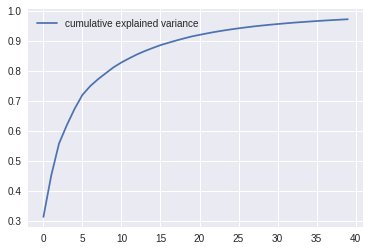

In [9]:
# cumulative explained variance ratio bears this out.  we could even go as low as 15 and still retain 90%b
plt.plot(range(40), np.cumsum(SVD.explained_variance_ratio_), label='cumulative explained variance')
plt.legend()

### what do these components look like?

In [10]:
feature_names = no_accounting_for_taste.columns

# the threshold here is in the SVD matrix for contribution amount, running -1 -> 1.  we're selecting for highly
# positive or highly negative components to see what's important in defining a genre component
def view_components(comp_num, threshold):
    i_components = []
    full_components = [(coef, feat) for coef, feat in zip(SVD.components_[comp_num], feature_names)]
    for i,j in full_components:
        if i > threshold or i < -threshold:
            i_components.append((i,j))
    component = pd.DataFrame(i_components, columns=['contribution','genre'])
    return component.sort_values('contribution', ascending=False)

component_5 = view_components(5, 0.15)
component_15 = view_components(15, 0.15)
component_25 = view_components(25, 0.15)

display(component_5)
display(component_15)
display(component_25)


,contribution,genre
3,0.405689,electronic
5,0.276029,experimental
1,0.263219,ambient
8,0.253777,post-rock
6,0.183915,female vocalists
0,0.175610,alternative
11,0.165517,shoegaze
4,-0.152014,emo
10,-0.168134,screamo
2,-0.223578,classic rock


,contribution,genre
5,0.282682,new wave
2,0.258304,folk
0,0.255874,80s
6,0.229941,post-punk
3,0.171903,german
1,0.159596,celtic
8,-0.168242,trance
7,-0.217415,soul
4,-0.406268,jazz


,contribution,genre
6,0.353495,japanese
2,0.228705,black metal
8,0.200825,soul
5,0.165966,j-pop
3,0.159378,emo
1,0.155583,J-rock
4,-0.178515,finnish
0,-0.205821,Classical
7,-0.235075,singer-songwriter


### now pull the 10 most similar users and identify genres in common to all but our random user

In [11]:
# set threshold for eliminating "bad" genres.  this is essentially our hyperparameter that filters for the 
# weighted number we've been carrying forward on our matrices, ranging from 0 to hundreds
# a threshold of 50 could mean 50 listens to an artist with 1 tag, or 100 listens to an artist with 2 equal tags, etc
threshold = 20

# return all genres from a given user with the given threshold, written specifically for df.apply
def get_genres(row):
    genre_list = []
    for column in no_accounting_for_taste.columns:
        if no_accounting_for_taste.loc[row['userid']][column] > threshold:
            genre_list.append(column)
    return genre_list

# return all genres from a given user that they ever listened to
def get_all_genres(userid):
    genre_list = []
    for column in no_accounting_for_taste.columns:
        if no_accounting_for_taste.loc[userid][column] > 0:
            genre_list.append(column)
    return genre_list

In [12]:
# look up a userid by index
def user_lookup(user_index):    
    return no_accounting_for_taste.iloc[user_index].name

# jaccard function to compare a given user to our target user, written specifically for df.apply
def jaccard(row):
    a = set(results_matrix.user_genres[results_matrix.index[0]])
    b = set(results_matrix.user_genres[row.name])
    numerator = a.intersection(b)
    denominator = a.union(b)
    diff_items = len(b.difference(a))
    return len(numerator)/len(denominator), diff_items

In [13]:
# transform the user's profile to the SVD and df our full user matrix
svd_user = SVD.transform(random_user) 
svd_df = pd.DataFrame(svd_matrix)

# add a cosine similarity column between the random user and the full user list
# at the moment this similarity takes into account ALL genres, even low-value ones. those are filtered out after 
# similarity is calculated.  this likely affects who is similar, but only marginally
svd_df['cosine_sim'] = cosine_similarity(svd_df, svd_user) 

# pull the 10 most similar users.  note: 0 = our user
results_matrix = svd_df[['cosine_sim']].sort_values('cosine_sim', ascending=False)[0:10] 

# look up userids, add them, and append a list of their genres
results_matrix['userid'] = results_matrix.index
results_matrix['userid'] = results_matrix['userid'].apply(user_lookup)
results_matrix['user_genres'] = results_matrix.apply(get_genres, axis=1)

# calculate the jaccard score to compare our random user to each other user
results_matrix['jaccard'] = results_matrix.apply(jaccard, axis=1)
results_matrix

,cosine_sim,userid,user_genres,jaccard
267,1.000000,33edd6efa2ed1cdfe8e478f02acba9db371162ad,"[00s, 90s, Hip-Hop, House, alternative, altern...","(1.0, 0)"
345,0.966759,1c8b27d2ccf46e0a85327e91b654914ca7593a58,"[00s, 60s, 80s, Canadian, Electroclash, Progre...","(0.3829787234042553, 19)"
343,0.964724,3e3d914f3f940653f40bd98b611b89f2b0f8d4d2,"[00s, 60s, 80s, 90s, Alt-country, Funk Rock, G...","(0.3230769230769231, 37)"
28,0.951037,a841973abcd903c2560931699893d5636dfdf30c,"[House, Nu Metal, alternative, alternative roc...","(0.3783783783783784, 9)"
29,0.950168,e271ff75e5b02d915048ef9abcdd0a3e7f3fd29b,"[Classical, Grunge, House, acoustic, alternati...","(0.3333333333333333, 17)"
287,0.949509,b8a9221e200b043cff5dd953d5d9886e11747077,"[80s, alternative, alternative rock, british, ...","(0.36666666666666664, 2)"
485,0.949113,54d92c81e78933a148fbe148bb5393c2b9316c9d,"[00s, 80s, 90s, Aussie, Canadian, Funk Rock, H...","(0.3793103448275862, 30)"
82,0.947588,8c4f2a594911b03becac9aff1007f29c3378790e,"[Progressive, Progressive rock, alternative, a...","(0.3191489361702128, 19)"
66,0.945482,21386d98b45ecd21c54ee9cb0083fcaed0b5140e,"[Acoustic Rock, American Idol, Progressive roc...","(0.26666666666666666, 17)"
495,0.944900,f6a417b06102f3407f46aa40db6570b12e4b2102,"[alternative, alternative rock, britpop, emo, ...","(0.26666666666666666, 2)"


In [14]:
# compare this to our list of top users from above based on vanilla cosine similarity.  
# high variance.  sometimes these are identical, other times very dissimilar.  
# SVD does something, but what?

# "Top Similar Listeners", top_n_users(random_usersha1)[:10]

In [15]:
# to reduce variance, we can compare the other user curated lists to the entire random_user_list
# this should eliminate us recommending a genre to someone who has listened to it a little bit, below the threshold

# pull the random user's full list, and everyone else in the top 5
random_user_full_list = set(get_all_genres(random_user.index[0]))
all_other_list = set(results_matrix['user_genres'][1:10].sum())

# all items appearing in our similar users' top lists and not in our random user's full list
diff_full_list = all_other_list.difference(random_user_full_list)

display( len(diff_full_list), diff_full_list )


# comparing filtered list to filtered list results in more junk in the rec list
random_user_list = set(results_matrix.user_genres[results_matrix.index[0]])
# diff_user_list = all_other_list.difference(random_user_list)
# display(len(diff_user_list), diff_user_list)

20

{'60s',
 'Alt-country',
 'American Idol',
 'Classical',
 'New Zealand',
 'baroque',
 'blues',
 'contemporary folk',
 'cute',
 'ethereal',
 'finnish',
 'glam rock',
 'indie folk',
 'liverpool',
 'mash-up',
 'mashup',
 'new age',
 'parody',
 'pop punk',
 'slowcore'}

In [16]:
# compare this to our initial recommendation.  
# there's some similarity, but we can now test between them!
display(user_recommend.head(15))


post-hardcore        20167.522535
metalcore            12676.796953
screamo              12261.748632
blues                12042.671628
pop punk             11597.653632
instrumental         11090.315529
Progressive metal    10860.192218
german                8052.190411
60s                   7249.024177
Stoner Rock           7099.973784
country               6886.563617
thrash metal          6858.800734
ska                   6794.339666
reggae                6600.149939
Power metal           6516.438736
dtype: float64

In [17]:
# our user's vector and top genres
no_accounting_for_taste.loc[random_usersha1][no_accounting_for_taste.loc[random_usersha1] > 0].sort_values(ascending=False).head(20)

rock                 476.717520
indie                397.892473
alternative          385.691300
italian              320.108375
britpop              273.317621
indie rock           230.464420
alternative rock     208.814669
pop                  193.953447
british              179.166261
folk                 173.745241
electronic           173.277522
dance                 73.473746
electronica           58.189265
singer-songwriter     49.848605
techno                40.790576
House                 37.462248
indie pop             36.348457
Hip-Hop               35.617857
italian pop           30.508503
pop rock              29.074516
Name: 33edd6efa2ed1cdfe8e478f02acba9db371162ad, dtype: float64

### Evaluations and Tuning: Hyperparameters
- Threshold
    - Set threshold for eliminating "bad" genres.  this filters for the weighted number we've been carrying forward on our matrices, ranging from 0 to hundreds
    - A threshold of 50 could mean 50 listens to an artist with 1 tag, or 100 listens to an artist with 2 equal tags, etc
    - Currently, this is sensitive to variance in plays between users, meaning that users with a low number of plays will recommend fewer new genres.  This may be ok. so long as we don't select an inactive user as our random user or too many inactive users in our comparison set.
- Number of top users to compare to
     - Another hyperparameter to tune is whether we pull from the top 5, 10, etc similar users when identifying the genres that our listener hasn't heard before.  too many risks wiping out everything, and too few risks recommending the same genre by a different name

### "Good" and "Junk" Genres
- Have I eliminated bad genres from recommendation, and do I also avoid obvious big ones?
- What do you think?

In [18]:
display( len(diff_full_list), diff_full_list )

user_recommend.head(15)

20

{'60s',
 'Alt-country',
 'American Idol',
 'Classical',
 'New Zealand',
 'baroque',
 'blues',
 'contemporary folk',
 'cute',
 'ethereal',
 'finnish',
 'glam rock',
 'indie folk',
 'liverpool',
 'mash-up',
 'mashup',
 'new age',
 'parody',
 'pop punk',
 'slowcore'}

post-hardcore        20167.522535
metalcore            12676.796953
screamo              12261.748632
blues                12042.671628
pop punk             11597.653632
instrumental         11090.315529
Progressive metal    10860.192218
german                8052.190411
60s                   7249.024177
Stoner Rock           7099.973784
country               6886.563617
thrash metal          6858.800734
ska                   6794.339666
reggae                6600.149939
Power metal           6516.438736
dtype: float64

### Remaining Problems
- The tags are still dirty.  The variance in names gets washed out when comparing groups of users, but on a per-user basis, there might be high variance among names, i.e., they might have just [alternative rock] in their tags, where everyone else has both [alternative rock, alternative], and as a result, the system recommends [alternative] to them.
- The threshold currently favors heavy listeners over light listeners.  If a light listener is selected, many of their tags get wiped out and they get recommendations for things that they probably already listen to
    - Maybe scale # of plays by total number of listens for the user in a future iteration?

- Other thoughts going forward on how to use SVD here:

http://sifter.org/~simon/journal/20061211.html

https://stats.stackexchange.com/questions/31096/how-do-i-use-the-svd-in-collaborative-filtering#35476